# BBM 409 - Programming Assignment 2
### Group 36: Aydan Çelik (2210356103)

### 1. Visualizing the Data

In [4]:
import pandas as pd
df = pd.read_csv("financial_risk_assessment.csv")

In [5]:
df.head()

,Age,Gender,Education Level,Marital Status,Income,Credit Score,Loan Amount,Loan Purpose,Employment Status,Years at Current Job,Payment History,Debt-to-Income Ratio,Assets Value,Number of Dependents,City,State,Country,Previous Defaults,Marital Status Change,Risk Rating
0,49,Male,PhD,Divorced,72799.0,688.0,45713.0,Business,Unemployed,19,Poor,0.154313,120228.0,0.0,Port Elizabeth,AS,Cyprus,2.0,2,Low
1,57,Female,Bachelor's,Widowed,NaN,690.0,33835.0,Auto,Employed,6,Fair,0.148920,55849.0,0.0,North Catherine,OH,Turkmenistan,3.0,2,Medium
2,21,Non-binary,Master's,Single,55687.0,600.0,36623.0,Home,Employed,8,Fair,0.362398,180700.0,3.0,South Scott,OK,Luxembourg,3.0,2,Medium
3,59,Male,Bachelor's,Single,26508.0,622.0,26541.0,Personal,Unemployed,2,Excellent,0.454964,157319.0,3.0,Robinhaven,PR,Uganda,4.0,2,Medium
4,25,Non-binary,Bachelor's,Widowed,49427.0,766.0,36528.0,Personal,Unemployed,10,Fair,0.143242,287140.0,NaN,New Heather,IL,Namibia,3.0,1,Low


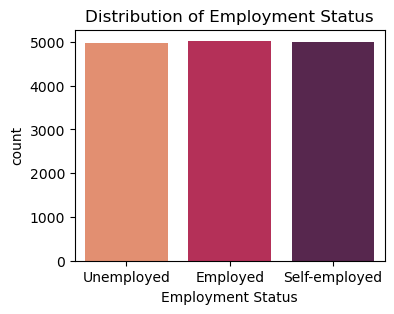

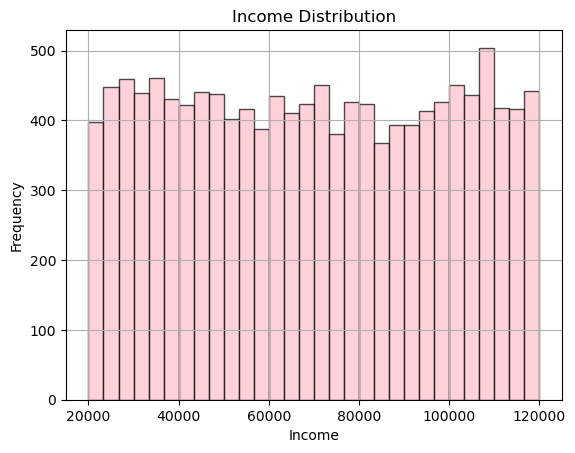

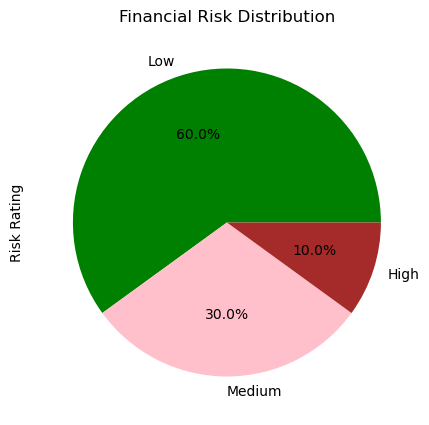

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 3))
sns.countplot(x="Employment Status", data=df, palette="rocket_r")
plt.xticks(rotation=0)
plt.title("Distribution of Employment Status")
plt.show()

print()

df["Income"].hist(bins=30, color="pink", edgecolor="black", alpha=0.7)
plt.title("Income Distribution")
plt.xlabel("Income")
plt.ylabel("Frequency")
plt.show()

print()

df["Risk Rating"].value_counts().plot(kind="pie", autopct="%1.1f%%", figsize=(5, 5), colors=["green", "pink", "brown"])
plt.title("Financial Risk Distribution")
plt.show()


Employment states and income data seem to be evenly distributed. When it comes to Financial Risk Distribution, the "Low" category dominates the others, the relatively small representation of "High risk" (10%) could impact the performance of the classification. It may lead to biased predictions, where a model could struggle to accurately classify high risk cases due to their low frequency.

### 2. Preprocessing

In [7]:
df = df.drop_duplicates()

print(df.isna().sum())
print()
print(f"Total missing data: {df.isna().sum().sum()}")

Age                         0
Gender                      0
Education Level             0
Marital Status              0
Income                   2250
Credit Score             2250
Loan Amount              2250
Loan Purpose                0
Employment Status           0
Years at Current Job        0
Payment History             0
Debt-to-Income Ratio        0
Assets Value             2250
Number of Dependents     2250
City                        0
State                       0
Country                     0
Previous Defaults        2250
Marital Status Change       0
Risk Rating                 0
dtype: int64

Total missing data: 13500


Since there are a lot of missing values in numerical data, instead of eliminating this rows, missings will be treated as a separate category. Replacing missings with averages can distort the distribution and introduce bias. Using a placeholder value like -9999 preserves the original data shape. Decision tree can learn to split on this value if it turns out to be predictive. It also avoids ambiguity during splits and ensures all instances can be routed through the tree.

In [8]:
missing_cols = ["Income", "Credit Score", "Loan Amount","Assets Value", "Number of Dependents", "Previous Defaults"]

for col in missing_cols:
    df[col] = df[col].fillna(-9999)

In [9]:
print(f"Total missing data: {df.isna().sum().sum()}")

Total missing data: 0


In order to be able to procecess the categorical data, they must be converted into a numerical format. For "Risk Rating", instead of sorting the class names, their numerical value will reflect their logical order. The mappings of label encodings will be stored in a dictionary for reverse lookup if needed in the future evaluations.

In [10]:
risk_rating_map = {
    "Low": 0,
    "Medium": 1,
    "High": 2
}

df["Risk Rating"] = df["Risk Rating"].map(risk_rating_map)

label_encodings = {}

def label_encode_column(df, column):
    unique_values = sorted(df[column].unique())  # Sorting the values
    mapping = {val: idx for idx, val in enumerate(unique_values)}
    df[column] = df[column].map(mapping)
    label_encodings[column] = mapping  # Store the mapping

    
categorical_cols = ["Gender", "Education Level", "Marital Status", "Loan Purpose", "Employment Status", "Payment History", 
                    "City", "State", "Country"]

for col in categorical_cols:
    label_encode_column(df, col)
    

After labeling:

In [11]:
df.head()

,Age,Gender,Education Level,Marital Status,Income,Credit Score,Loan Amount,Loan Purpose,Employment Status,Years at Current Job,Payment History,Debt-to-Income Ratio,Assets Value,Number of Dependents,City,State,Country,Previous Defaults,Marital Status Change,Risk Rating
0,49,1,3,0,72799.0,688.0,45713.0,1,2,19,3,0.154313,120228.0,0.0,7200,3,55,2.0,2,0
1,57,0,0,3,-9999.0,690.0,33835.0,0,0,6,1,0.148920,55849.0,0.0,6077,40,223,3.0,2,1
2,21,2,2,2,55687.0,600.0,36623.0,2,0,8,1,0.362398,180700.0,3.0,9019,41,125,3.0,2,1
3,59,1,0,2,26508.0,622.0,26541.0,3,2,2,0,0.454964,157319.0,3.0,7946,44,226,4.0,2,1
4,25,2,0,3,49427.0,766.0,36528.0,3,2,10,1,0.143242,287140.0,-9999.0,5417,17,148,3.0,1,0


In [12]:
# Splitting the data

from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(df, test_size=0.30, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.50, random_state=42)

### 3. ID3 Decision Tree Implementation

This is my ID3 decision tree function. It builds the tree by choosing the best attribute to split the data, using information gain. If the attribute is continuous (like Age or Income), it finds the best value (threshold) to split on. It handles missing values (which I filled as -9999) by creating a separate "Missing" branch. The function is recursive, so it keeps building subtrees until the data is perfectly classified or there are no more features left.

In [13]:
import numpy as np

def entropy(df, attribute, target_col): # for an attribute
    labels = target_col.unique()
    total_count = attribute.shape[0]
    entropy = 0

    for label in labels:
        count = attribute[attribute[target_col.name] == label].shape[0]

        if count != 0:
            prob = count / total_count
            entropy += -prob * np.log2(prob)

    return entropy


def total_entropy(df, target_col):
    total_rows = df.shape[0]
    labels = target_col.unique()
    total_entropy = 0
    
    for label in labels:
        count = df[target_col == label].shape[0]
        probability = count/total_rows
        entropy = -probability * np.log2(probability) 
        total_entropy += entropy
    
    return total_entropy


def information_gain(df, attr_name, target_col):
    class_list = target_col.unique()
    attr_values = df[attr_name].unique()
    total_rows = df.shape[0]
    val_gain = 0.0
    
    for val in attr_values:
        val_data = df[df[attr_name] == val]
        val_count = val_data.shape[0]

        val_entropy = entropy(df, val_data, target_col)
        prob = val_count/total_rows
        
        val_gain += prob * val_entropy 
        
    return total_entropy(df, target_col) - val_gain
    

def most_common_label(column):
    return column.value_counts().idxmax()


def split_for_continuous(df, attr, target_col):
    # sort by the continuous column
    # ggnore rows where the value is -9999
    sorted_df = df[df[attr] != -9999][[attr, target_col.name]].sort_values(by=attr)
                
    thresholds = []
    
    for i in range(len(sorted_df) - 1):
        value = sorted_df.iloc[i][attr]
        next_value = sorted_df.iloc[i + 1][attr]
        
        label = sorted_df.iloc[i][target_col.name]
        next_label = sorted_df.iloc[i + 1][target_col.name]

        if label != next_label:
            # Midpoint between two values
            threshold = (value + next_value) / 2
            thresholds.append(threshold)

    # try each threshold and calculate information gain
    best_gain = -1
    best_threshold = None

    for threshold in thresholds:
        # Create a binary column, true if value < threshold
        df_temp = df.copy()
        df_temp["temp_split"] = df_temp[attr] < threshold

        gain = information_gain(df_temp, "temp_split", target_col)
        if gain > best_gain:
            best_gain = gain
            best_threshold = threshold

    return best_threshold, best_gain



In [14]:
def ID3(df, attributes, continuous_attr, max_depth=None, current_depth=0,
        min_samples_split=20, min_gain=0.0):
    
    target_col = df["Risk Rating"]

    # base case: if all target labels are the same, just return that label
    if len(np.unique(target_col)) == 1:
        return np.unique(target_col)[0]

    # base case: if we run out of attributes, just return the most common label
    if len(attributes) == 0:
        return most_common_label(target_col)
    
    if max_depth is not None and current_depth >= max_depth:
        return most_common_label(target_col)

    # stop if not enough samples to split
    if df.shape[0] < min_samples_split:
        return most_common_label(target_col)

    # keep track of best attribute and best info gain
    best_attr = None
    best_gain = -1
    best_threshold = None  # only for continuous
    is_continuous = False  # flag to check if best attr is continuous
    
    # search for the best attribute (and threshold if needed)
    for attr in attributes:
        
        if attr in continuous_attr:
            threshold, gain = split_for_continuous(df, attr, target_col)
            
            if gain > best_gain:
                best_attr = attr
                best_gain = gain
                best_threshold = threshold
                is_continuous = True
                
        else:
            gain = information_gain(df, attr, target_col)
            if gain > best_gain:
                best_attr = attr
                best_gain = gain
                best_threshold = None
                is_continuous = False
            
                
    if best_gain < min_gain:
        return most_common_label(target_col)


    # start building the tree
    if is_continuous:
        
        # split data into: < threshold, >= threshold, and missing
        missing = df[df[best_attr] == -9999]
        left = df[df[best_attr] < best_threshold]
        right = df[df[best_attr] >= best_threshold]
        
        # exclude the attribute just used
        new_attrs = [attr for attr in attributes if attr != best_attr]
        
        tree = {"attribute": best_attr, 
                "threshold": best_threshold,
                "is_continuous": True,
                "info_gain": best_gain, # Storing info_gain for pruning
                "children": {}}

            
        tree["children"][True] = ID3(left, new_attrs, continuous_attr, max_depth, 
                                     current_depth + 1, min_samples_split, min_gain)

        tree["children"][False] = ID3(right, new_attrs, continuous_attr, max_depth, 
                                      current_depth + 1, min_samples_split, min_gain)
        
        if len(missing) > 0:
            tree["children"]["Missing"] = ID3(missing, new_attrs, continuous_attr, 
                                              max_depth, current_depth + 1, min_samples_split, min_gain)

    
    else:
        tree = {"attribute": best_attr, 
                "info_gain": best_gain, # Storing info_gain for pruning
                "is_continuous": False,
                "children": {}}  

        
        # for each unique value of the best attribute
        for value in np.unique(df[best_attr]):
            # create a subset of the data where the attribute equals that value
            subset = df[df[best_attr] == value]
            
            # Exclude the attribute just used
            new_attrs = [attr for attr in attributes if attr != best_attr]
            
            # recursively build subtree for this value
            subtree = ID3(subset, new_attrs, continuous_attr, max_depth, current_depth + 1, min_samples_split, min_gain)
            tree["children"][value] = subtree
            

    return tree


### 4. Training The Models

For chosen attributes, I skipped "City", "State", and "Country" because they have too many unique values. Decision trees don't work well with features that have so many categories, especially if most of them appear only a few times. It can lead to overfitting or unnecessary splits that don’t really help the model. 

All the other columns were included because they are either categorical or continuous features that could actually help in predicting the risk level of a person. 

In [15]:
continuous_attr = ["Age", "Income", "Credit Score", "Loan Amount", "Years at Current Job", "Debt-to-Income Ratio", 
                         "Assets Value", "Number of Dependents", "Previous Defaults", "Marital Status Change"]


chosen_attributes = ["Age", "Gender", "Education Level", "Marital Status", "Income", "Credit Score", "Loan Amount", 
              "Loan Purpose", "Employment Status", "Years at Current Job", "Payment History", "Debt-to-Income Ratio", 
              "Assets Value", "Number of Dependents", "Previous Defaults", "Marital Status Change"]


In [16]:
%%time
model0 = ID3(train_df, chosen_attributes, continuous_attr, max_depth=None, min_samples_split=30, min_gain=0.00)

Wall time: 28min 1s


In [17]:
%%time
model1 = ID3(train_df, chosen_attributes, continuous_attr, max_depth=5, min_samples_split=80, min_gain=0.00)

Wall time: 20min 47s


In [19]:
%%time
model2 = ID3(train_df, chosen_attributes, continuous_attr, max_depth=8, min_samples_split=100, min_gain=0.00)

Wall time: 24min 40s


### Model Evaluation

In [23]:
def predict_row(tree, row, default_label):
    current = tree
    
    if not isinstance(current, dict):
        return current

    # after pruning, check if it is a leaf
    if "leaf_value" in current and current["leaf_value"] is not None:
        return current["leaf_value"]

    while isinstance(current, dict) and "children" in current:
        
        attr_name = current["attribute"]
        is_cont = current["is_continuous"]
        
        try:
            val = row[attr_name]
        except:
            print(current)
            exit()

        if is_cont:
            if val == -9999:
                current = current["children"].get("Missing", default_label)
            elif val < current["threshold"]:
                current = current["children"][True]
            else:
                current = current["children"][False]
        else:
            if val in current["children"]:
                current = current["children"][val]
            else:
                current = default_label

    return current  # final prediction (a label)


# This applies the prediction to the whole DataFrame
def predict(tree, df, default_label):
    return df.apply(lambda row: predict_row(tree, row, default_label), axis=1)


In [24]:
fallback_label = most_common_label(train_df["Risk Rating"])

test_y = test_df["Risk Rating"]
test_X = test_df.drop("Risk Rating", axis=1)

y_pred0 = predict(model0, test_X, fallback_label)
y_pred1 = predict(model1, test_X, fallback_label)
y_pred2 = predict(model2, test_X, fallback_label)

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

def evaluate_model(y_true, y_pred, model_name="Model"):
    print(f"--- {model_name} ---")
    print("Accuracy:  {:.2f}".format(accuracy_score(y_true, y_pred)))
    print("Precision:  {:.2f}".format(precision_score(y_true, y_pred, average='macro', zero_division=0)))
    print("Recall:  {:.2f}".format(recall_score(y_true, y_pred, average='macro')))
    print("F1 Score:  {:.2f}".format(f1_score(y_true, y_pred, average='macro')))
    print("Confusion Matrix:")
    print()
    print(confusion_matrix(y_true, y_pred))
    print()
    print()


I am comparing 3 ID3 decision tree models using different max_depth and min_samples_split settings. Even though I added min_gain as a hyperparameter, I noticed that the information gain values were generally really low across different splits. Because of that, min_gain didn’t make much of a difference during training, so I ended up not using it in my final models.  

The goal is to predict the Risk Rating, which has 3 classes:

0 = Low (60% of data)

1 = Medium (30%)

2 = High (10%)

The trees were built using 16 out of 19 attributes.

##### Model 0
This model attempted to predict all classes, including minority ones, resulting in a more balanced but less accurate overall performance. It achieved the highest F1 score, indicating better sensitivity to all classes, especially compared to the shallow models. However, it also had the lowest accuracy and took the longest to train due to its complexity and depth.

In [26]:
evaluate_model(test_y, y_pred0, "Model 0")  # with max_depth=None,  min_samples_split=30,  min_gain=0.00

--- Model 0 ---
Accuracy:  0.53
Precision:  0.34
Recall:  0.34
F1 Score:  0.32
Confusion Matrix:

[[1046  274   30]
 [ 513  148   10]
 [ 177   48    4]]




##### Model 1
With a shallow tree and fewer splits, the model gets better accuracy, but that’s just because most samples are Low (60%). It barely predicts Medium and doesn’t predict High at all. So it’s biased toward the majority class and isn’t really good at spotting risky (High) customers.

In [27]:
evaluate_model(test_y, y_pred1, "Model 1")  # with max_depth=5,  min_samples_split=80,  min_gain=0.00

--- Model 1 ---
Accuracy:  0.60
Precision:  0.34
Recall:  0.33
F1 Score:  0.26
Confusion Matrix:

[[1338    9    3]
 [ 662    7    2]
 [ 228    1    0]]




##### Model 2
This model matched Model 1 in accuracy but slightly improved recall and precision, suggesting a better balance between detecting minority classes and maintaining overall performance. However, its F1 score was still lower than that of Model 0, indicating that further tuning is needed to improve minority class detection.

In [28]:
evaluate_model(test_y, y_pred2, "Model 2")  # with max_depth=8,  min_samples_split=100, min_gain=0.00

--- Model 2 ---
Accuracy:  0.60
Precision:  0.35
Recall:  0.34
F1 Score:  0.26
Confusion Matrix:

[[1341    9    0]
 [ 663    8    0]
 [ 228    1    0]]




### 5. Model Comparison
Deeper trees (like Model 0) take significantly more time to train and predict. They generate more splits, compute more information gain values, and have more complex decision paths, making them harder to interpret.

In contrast, simpler models (like Model 1) run and train quickly, but they tend to overfit to the dominant class, which is problematic in imbalanced datasets.

Model 0 offers the most balanced classification, at the cost of lower accuracy and slower training.

Model 1 is the fastest and most accurate, but fails to recognize minority classes.

Model 2 represents a middle ground, with decent overall metrics but still room for improvement in class balance.

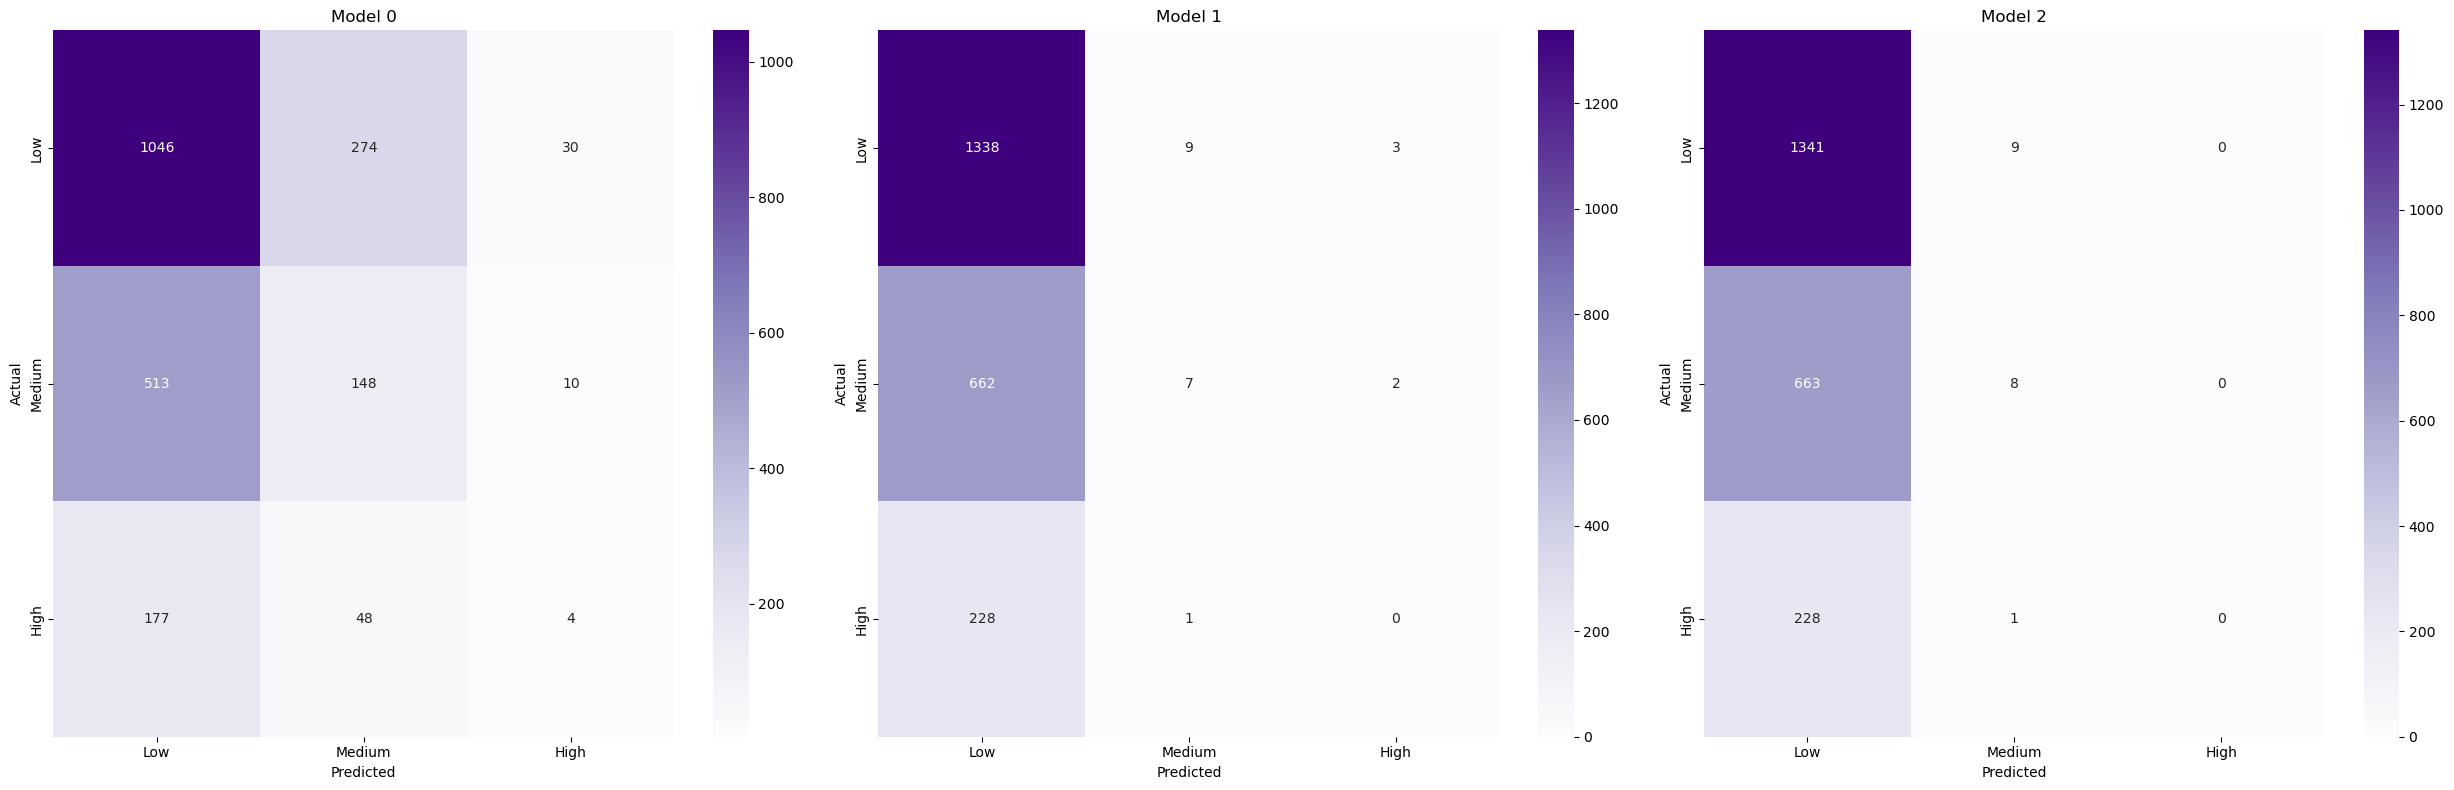

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_true = test_df["Risk Rating"]

y_preds = [y_pred0, y_pred1, y_pred2]

model_names = ["Model 0", "Model 1", "Model 2"]

fig, axes = plt.subplots(1, 3, figsize=(25, 8))

for i, ax in enumerate(axes):
    cm = confusion_matrix(y_true, y_preds[i])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
                xticklabels=["Low", "Medium", "High"],
                yticklabels=["Low", "Medium", "High"],
                ax=ax)
    ax.set_title(model_names[i])
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.show()


###### Misclassifications
All five of these individuals belong to the minority classes. The models are biased towards the majority class which results in this misclassifations.

Some of the data are missing, like Income and Number of Dependants (spotted as -9999). This might have made it harder for the classification.

Some of the features of these individuals contain conflicting values. For example, the row 438 has high education and is employed with an excellent payment history which would logically result in a "Low" classification by the decision tree. These conflicts, combined with the missing values, make the data harder for the tree to categorize cleanly.

Columns like City, State, and Country were excluded from the model because they had too many unique values. However, location might still influence risk (like economic differences). Since this information is not used, the model might miss some important details.

In [33]:
y_true = test_df["Risk Rating"]
misclassified = test_df[y_true != y_pred3].copy()

# reverse all mappings for label-encode
reversed_encodings = {col: {v: k for k, v in mapping.items()} for col, mapping in label_encodings.items()}

# apply reverse mapping to misclassified rows
for col in categorical_cols:
    misclassified[col] = misclassified[col].map(reversed_encodings[col])

misclassified.head()

,Age,Gender,Education Level,Marital Status,Income,Credit Score,Loan Amount,Loan Purpose,Employment Status,Years at Current Job,Payment History,Debt-to-Income Ratio,Assets Value,Number of Dependents,City,State,Country,Previous Defaults,Marital Status Change,Risk Rating
438,19,Non-binary,Master's,Married,-9999.0,626.0,41316.0,Business,Employed,0,Excellent,0.103289,244728.0,3.0,Garciamouth,OK,Ethiopia,2.0,2,1
6594,46,Non-binary,High School,Single,98346.0,793.0,24661.0,Business,Unemployed,7,Fair,0.551954,292897.0,-9999.0,Masseyland,FL,Guinea-Bissau,2.0,2,2
5437,49,Male,PhD,Divorced,84261.0,640.0,49666.0,Home,Employed,11,Good,0.475576,299724.0,0.0,Erikaberg,AZ,Jordan,4.0,2,1
7520,45,Male,High School,Widowed,67511.0,702.0,10251.0,Business,Self-employed,16,Good,0.382403,-9999.0,1.0,Gonzalestown,NJ,Samoa,1.0,1,1
2992,45,Female,Master's,Widowed,107638.0,675.0,20023.0,Business,Unemployed,18,Fair,0.269525,185101.0,-9999.0,Arthurtown,PW,Portugal,2.0,2,2


##### Model Choice
Model 0 is the preferred choice due to its strong performance in capturing patterns across all classes, particularly the minority ones. Although it has the lowest accuracy (%53), it achieves the highest F1 score (0.32) among all models, indicating a more balanced ability to detect all risk levels, not just the dominant class.

Unlike Model 1 and Model 2, which mostly predict the majority class (Low risk), Model 0 makes more classifications on Medium and High risk instances. This is especially important in imbalanced datasets where accuracy can be misleading and it can be further imroved with post-pruning.

In [34]:
def print_tree_paths(tree, path=[]):
    # at a leaf node, print the full path
    if not isinstance(tree, dict) or "children" not in tree:
        print(" -> ".join(path) + f" -> [{tree}]")
        return

    attr = tree["attribute"]
    is_cont = tree["is_continuous"]
    threshold = tree.get("threshold")

    # go through each child node
    for branch, child in tree["children"].items():
        if is_cont:
            if branch == True:
                rule = f"{attr} < {threshold}"
            elif branch == False:
                rule = f"{attr} >= {threshold}"
            else:
                rule = f"{attr} is missing"
        else:
            if branch == "Missing":
                rule = f"{attr} is missing"
            else:
                rule = f"{attr} == {branch}"

        # keep adding to the path and go deeper
        print_tree_paths(child, path + [rule])


In [42]:
print_tree_paths(model0)

Years at Current Job < 18.0 -> Debt-to-Income Ratio < 0.599414262211613 -> Credit Score < 748.0 -> Marital Status == 0 -> Loan Amount < 49439.0 -> Income < 78658.0 -> Marital Status Change < 0.5 -> Payment History == 0 -> Age < 26.5 -> [0]
Years at Current Job < 18.0 -> Debt-to-Income Ratio < 0.599414262211613 -> Credit Score < 748.0 -> Marital Status == 0 -> Loan Amount < 49439.0 -> Income < 78658.0 -> Marital Status Change < 0.5 -> Payment History == 0 -> Age >= 26.5 -> Loan Purpose == 0 -> [0]
Years at Current Job < 18.0 -> Debt-to-Income Ratio < 0.599414262211613 -> Credit Score < 748.0 -> Marital Status == 0 -> Loan Amount < 49439.0 -> Income < 78658.0 -> Marital Status Change < 0.5 -> Payment History == 0 -> Age >= 26.5 -> Loan Purpose == 1 -> [0]
Years at Current Job < 18.0 -> Debt-to-Income Ratio < 0.599414262211613 -> Credit Score < 748.0 -> Marital Status == 0 -> Loan Amount < 49439.0 -> Income < 78658.0 -> Marital Status Change < 0.5 -> Payment History == 0 -> Age >= 26.5 ->

### 6. Pruning the Decision Tree

In [36]:
def find_twigs(tree):
    twigs = []

    def search(node):
        
        # if it is a leaf
        if not isinstance(node, dict) or "children" not in node or node["children"] is None:
            return
        
        children = node["children"]
        is_twig = True
        
        for child in children.values():
            # if the child is not a leaf, the node is not a twig
            if isinstance(child, dict) and child.get("children") is not None:
                is_twig = False
                break

        # all children are leaves
        if is_twig:
            twigs.append(node)
            
            
        else:
            # if child is not a leaf, keep searching
            for child in children.values():
                if isinstance(child, dict):
                    search(child)

    search(tree)
    return twigs

In [69]:
from sklearn.metrics import accuracy_score

def prune_tree(tree, val_df, val_y, default_label=0):
    last_accuracy = accuracy_score(val_y, predict(tree, val_df, default_label))
    print("last accuracy: ", last_accuracy)
    pruned = []
    
    twig_nodes = find_twigs(tree)

    while True:

        # no more twigs left
        if not twig_nodes:
            break

        # pick twig with least info gain
        twig = min(twig_nodes, key=lambda node: node.get("info_gain", float("inf")))

        # backup info for restoring if needed
        og_twig = twig.copy()
        
        
        child_labels = []
        # compute the majority label of this twig’s children
        for child in twig["children"].values():
            if isinstance(child, dict):
                if "leaf_value" in child:
                    child_labels.append(child["leaf_value"])
                else:
                    child_labels.append(child)


        if not child_labels:
            majority_label = default_label
        else:
            majority_label = max(set(child_labels), key=child_labels.count)

        twig.clear()
        twig.update({"leaf_value": majority_label})

        predicted = predict(tree, val_df, default_label)
        
        

        current_accuracy = accuracy_score(val_y, predicted)
        print("current accuracy: ", current_accuracy)

        if current_accuracy >= last_accuracy:
            last_accuracy = current_accuracy
            pruned.append(og_twig.get("attribute", "Missing"))
        
            print(f"Pruned: {og_twig.get('attribute')} | Accuracy: {current_accuracy:.2f}")
        else:
            # revert if accuracy got worse
            twig.clear()
            twig.update(og_twig)
            twig_nodes.remove(twig)
            continue

    return tree, pruned


In [70]:
val_y = val_df["Risk Rating"]
val_X = val_df.drop("Risk Rating", axis=1)

train_y = train_df["Risk Rating"]
train_X = train_df.drop("Risk Rating", axis=1)

test_y = test_df["Risk Rating"]
test_X = test_df.drop("Risk Rating", axis=1)

In [71]:
import copy
# Copying the original tree before modifying it
pruned_model = copy.deepcopy(model0)

pruned_model, pruned_attrs = prune_tree(pruned_model, val_X, val_y, default_label=0)

last accuracy:  0.5155555555555555
current accuracy:  0.5151111111111111
current accuracy:  0.5155555555555555
Pruned: Gender | Accuracy: 0.52
current accuracy:  0.5155555555555555
Pruned: Payment History | Accuracy: 0.52
current accuracy:  0.5155555555555555
Pruned: Payment History | Accuracy: 0.52
current accuracy:  0.5173333333333333
Pruned: Payment History | Accuracy: 0.52
current accuracy:  0.5173333333333333
Pruned: Number of Dependents | Accuracy: 0.52
current accuracy:  0.5173333333333333
Pruned: Gender | Accuracy: 0.52
current accuracy:  0.516
current accuracy:  0.5182222222222223
Pruned: Loan Purpose | Accuracy: 0.52
current accuracy:  0.5182222222222223
Pruned: Gender | Accuracy: 0.52
current accuracy:  0.5182222222222223
Pruned: Gender | Accuracy: 0.52
current accuracy:  0.5182222222222223
Pruned: Gender | Accuracy: 0.52
current accuracy:  0.5195555555555555
Pruned: Employment Status | Accuracy: 0.52
current accuracy:  0.5195555555555555
Pruned: Loan Purpose | Accuracy: 0.5

current accuracy:  0.544
Pruned: Gender | Accuracy: 0.54
current accuracy:  0.544
Pruned: Marital Status | Accuracy: 0.54
current accuracy:  0.544
Pruned: Loan Purpose | Accuracy: 0.54
current accuracy:  0.544
Pruned: Assets Value | Accuracy: 0.54
current accuracy:  0.544
Pruned: Loan Purpose | Accuracy: 0.54
current accuracy:  0.544
Pruned: Number of Dependents | Accuracy: 0.54
current accuracy:  0.5435555555555556
current accuracy:  0.5444444444444444
Pruned: Loan Purpose | Accuracy: 0.54
current accuracy:  0.5444444444444444
Pruned: Assets Value | Accuracy: 0.54
current accuracy:  0.5457777777777778
Pruned: Assets Value | Accuracy: 0.55
current accuracy:  0.5457777777777778
Pruned: Assets Value | Accuracy: 0.55
current accuracy:  0.5457777777777778
Pruned: Payment History | Accuracy: 0.55
current accuracy:  0.5457777777777778
Pruned: Loan Purpose | Accuracy: 0.55
current accuracy:  0.5466666666666666
Pruned: Age | Accuracy: 0.55
current accuracy:  0.5466666666666666
Pruned: Assets V

KeyboardInterrupt: 

In [72]:
print("Post-pruning performance:")

for name, X, y in [("Train", train_X, train_y), ("Test", test_X, test_y), ("Validation", val_X, val_y)]:
    pred = predict(pruned_model, X, default_label=0)
    print(f"\n{name} Set:")
    evaluate_model(y, pred, model_name="Post-Pruned Tree")

Post-pruning performance:

Train Set:
--- Post-Pruned Tree ---
Accuracy:  0.63
Precision:  0.58
Recall:  0.40
F1 Score:  0.39
Confusion Matrix:

[[5893  380   35]
 [2486  654   22]
 [ 860  106   64]]



Test Set:
--- Post-Pruned Tree ---
Accuracy:  0.56
Precision:  0.33
Recall:  0.34
F1 Score:  0.31
Confusion Matrix:

[[1178  148   24]
 [ 575   88    8]
 [ 199   28    2]]



Validation Set:
--- Post-Pruned Tree ---
Accuracy:  0.57
Precision:  0.34
Recall:  0.34
F1 Score:  0.31
Confusion Matrix:

[[1183  136   23]
 [ 562   93   12]
 [ 210   29    2]]




The post-pruned tree shows improved generalization compared to the unpruned version. While training accuracy is still relatively high (63%), the test and validation F1 scores (0.31) indicate that the model maintains a better balance across classes. Although there is a slight drop in accuracy after pruning, the model avoids overfitting and performs more consistently across all sets.

In [73]:
print("\nPruned Attributes:", pruned_attrs)


Pruned Attributes: []
